# Churn Prediction Model using Decision Trees

This notebook creates a churn prediction model using decision trees. It includes:
- Data loading and preprocessing
- Exploratory data analysis with visualizations
- Normalization and PCA
- Model training with GridSearchCV
- Evaluation of model performance

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set up the required folders
os.makedirs('eda', exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
train_results_folder = f'trainresults/{timestamp}'
os.makedirs(train_results_folder, exist_ok=True)
print(f"Results will be saved to: {train_results_folder}")

Results will be saved to: trainresults/20250303_203039


## 1. Load and Explore the Dataset

In [4]:
# Load the Excel sheet
df = pd.read_csv('loblaws-csv.csv')

# Display the first few rows of the dataset
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (5630, 20)


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,130


In [5]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64


In [6]:
# Basic statistics
print("\nBasic statistics of the dataset:")
df.describe()


Basic statistics of the dataset:


,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.000000,5366.000000,5630.000000,5379.000000,5375.000000,5630.000000,5630.000000,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
mean,52815.500000,0.168384,10.189899,1.654707,15.639896,2.931535,3.688988,3.066785,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.221492
std,1625.385339,0.374240,8.557241,0.915389,8.531475,0.721926,1.023999,1.380194,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.193869
min,50001.000000,0.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51408.250000,0.000000,2.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,146.000000
50%,52815.500000,0.000000,9.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.000000
75%,54222.750000,0.000000,16.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.000000
max,55630.000000,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,325.000000


## 2. Exploratory Data Analysis (EDA)

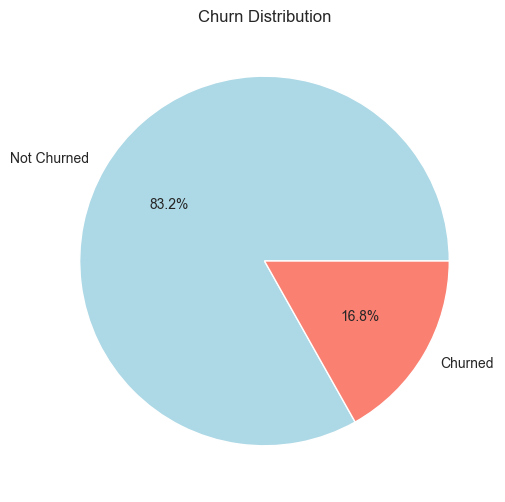

In [7]:
# Class distribution
plt.figure(figsize=(8, 6))
churn_counts = df['Churn'].value_counts()
plt.pie(churn_counts, labels=['Not Churned', 'Churned'], autopct='%1.1f%%', colors=['lightblue', 'salmon'])
plt.title('Churn Distribution')
plt.savefig('eda/churn_distribution.png')
plt.show()

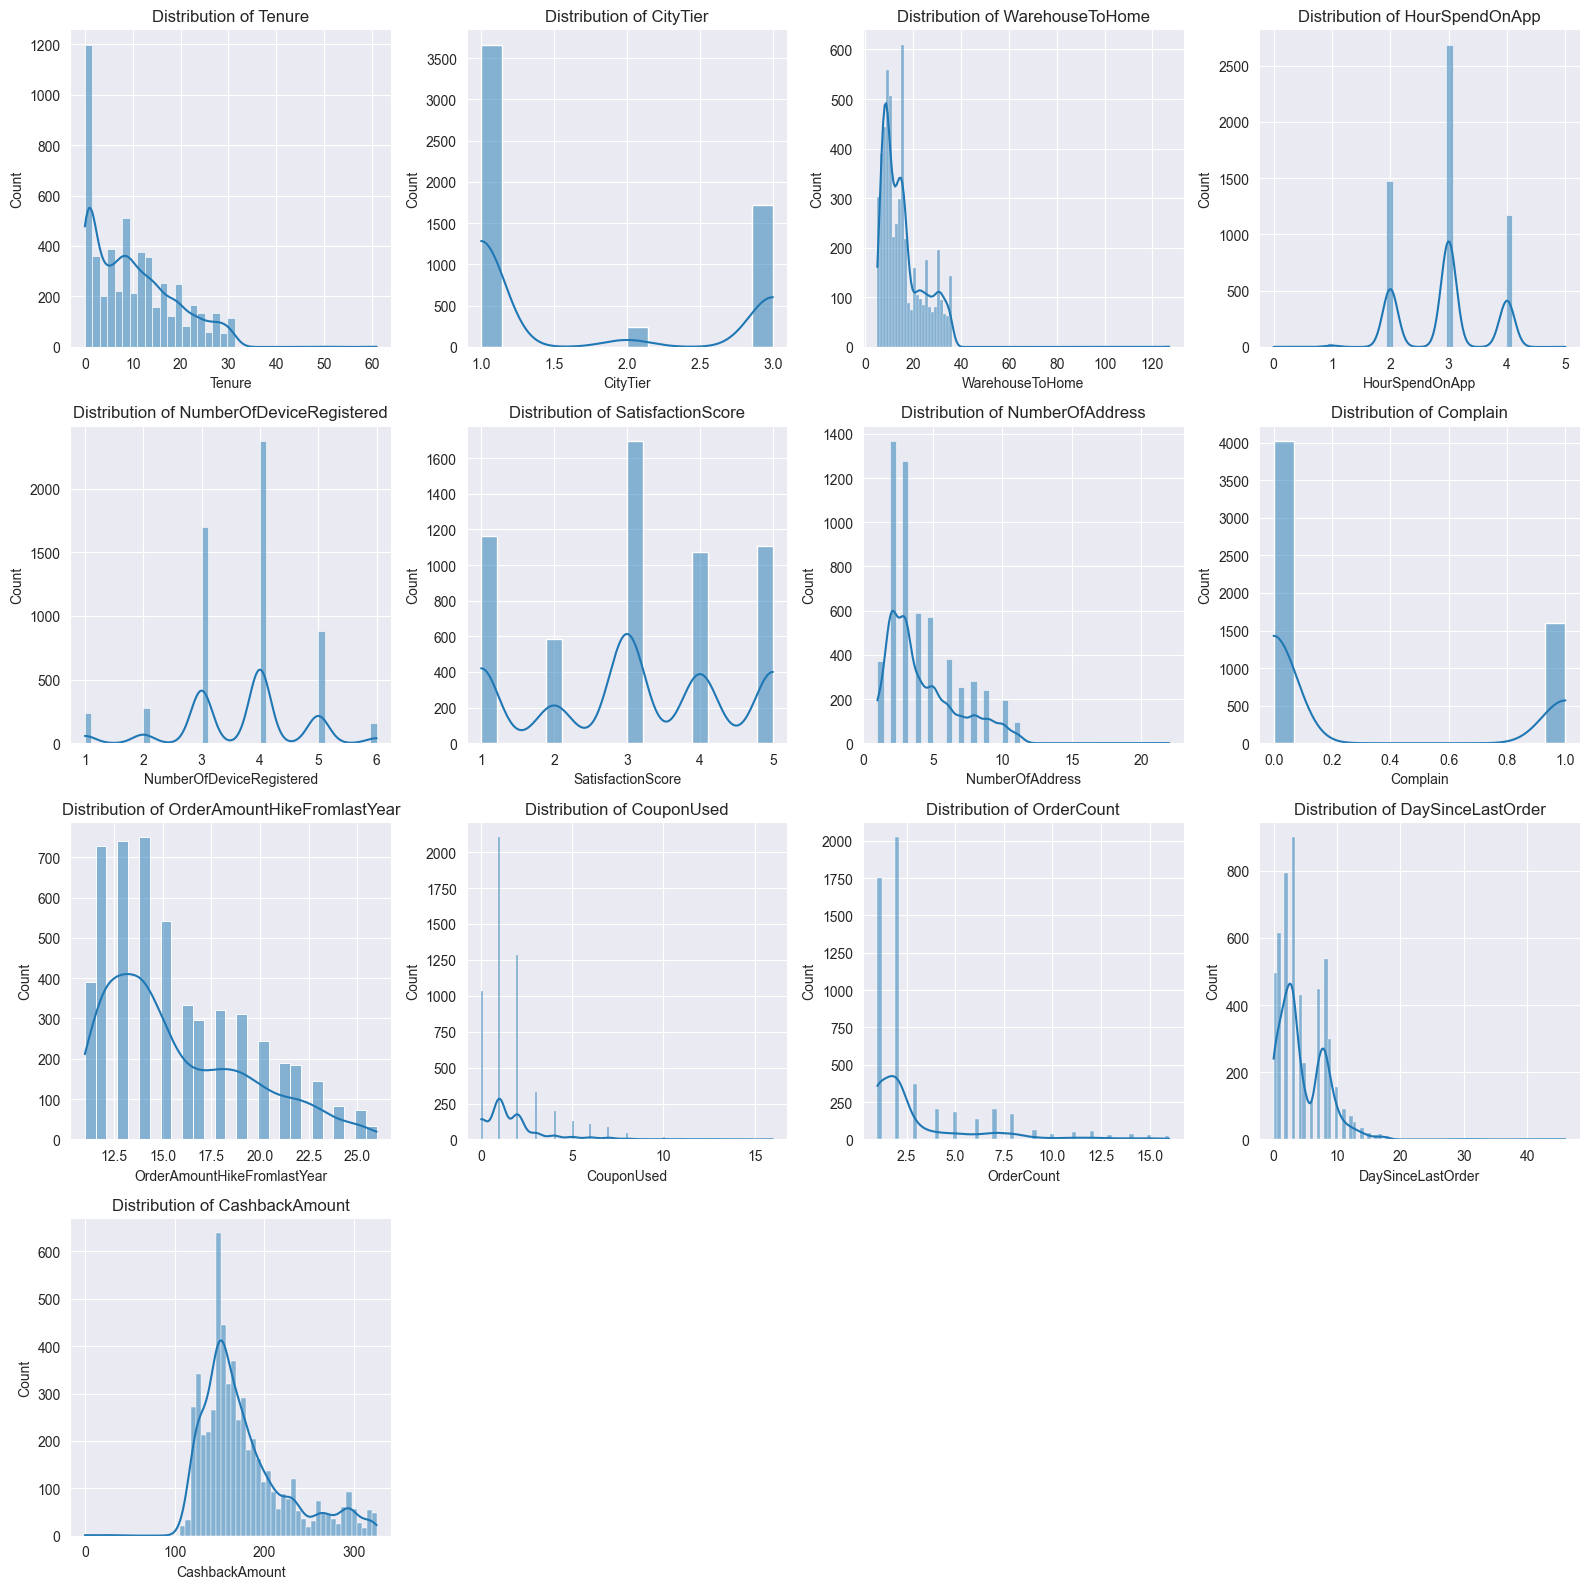

In [8]:
# Histograms for numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'CustomerID' in numerical_features:
    numerical_features.remove('CustomerID')
if 'Churn' in numerical_features:
    numerical_features.remove('Churn')

plt.figure(figsize=(16, 16))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.savefig('eda/numerical_distributions.png')
plt.show()

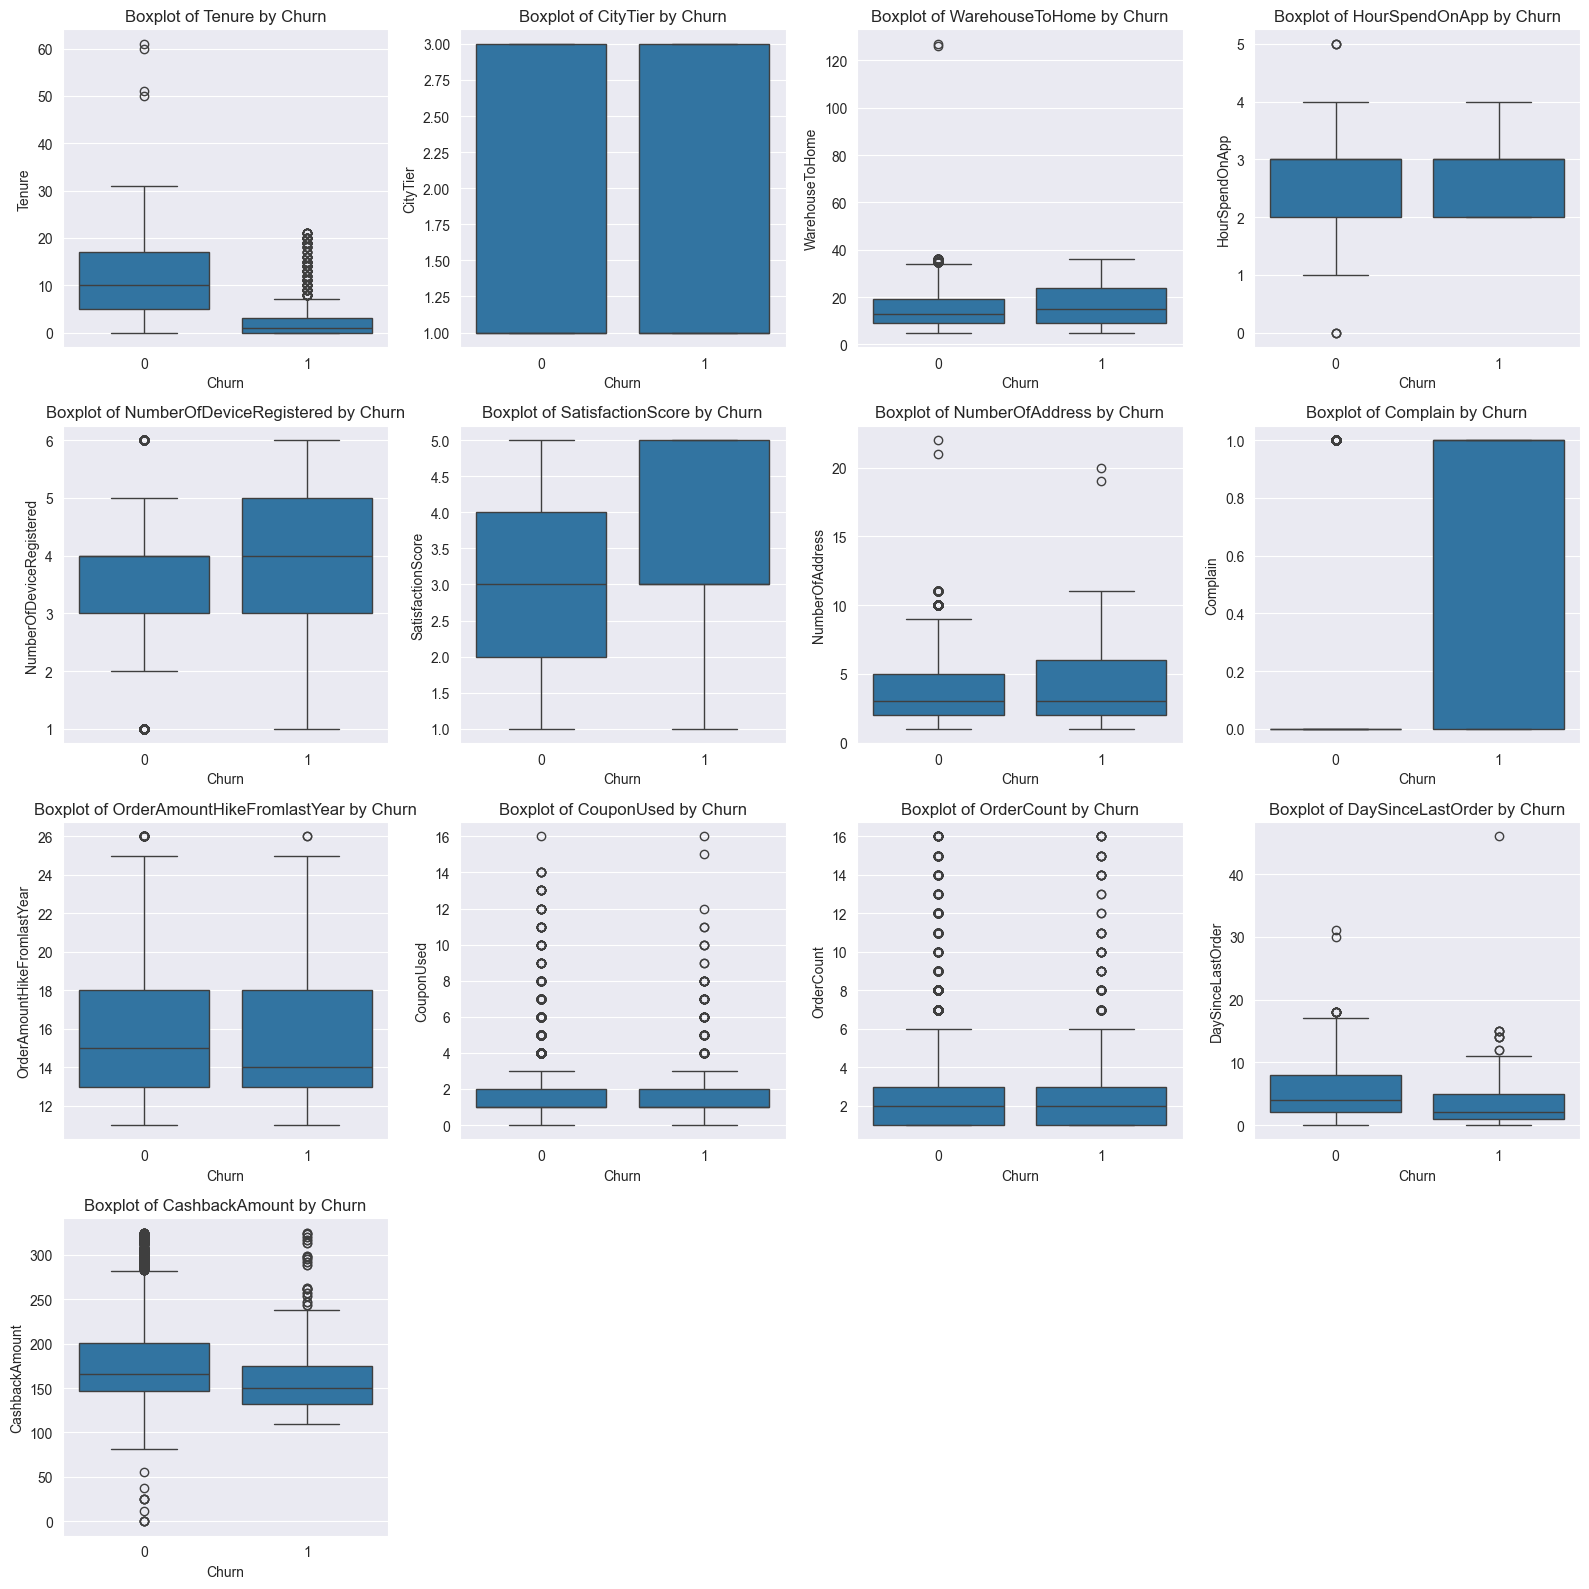

In [9]:
# Box plots for numerical features by Churn
plt.figure(figsize=(16, 16))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x='Churn', y=feature, data=df)
    plt.title(f'Boxplot of {feature} by Churn')
plt.tight_layout()
plt.savefig('eda/boxplots_by_churn.png')
plt.show()

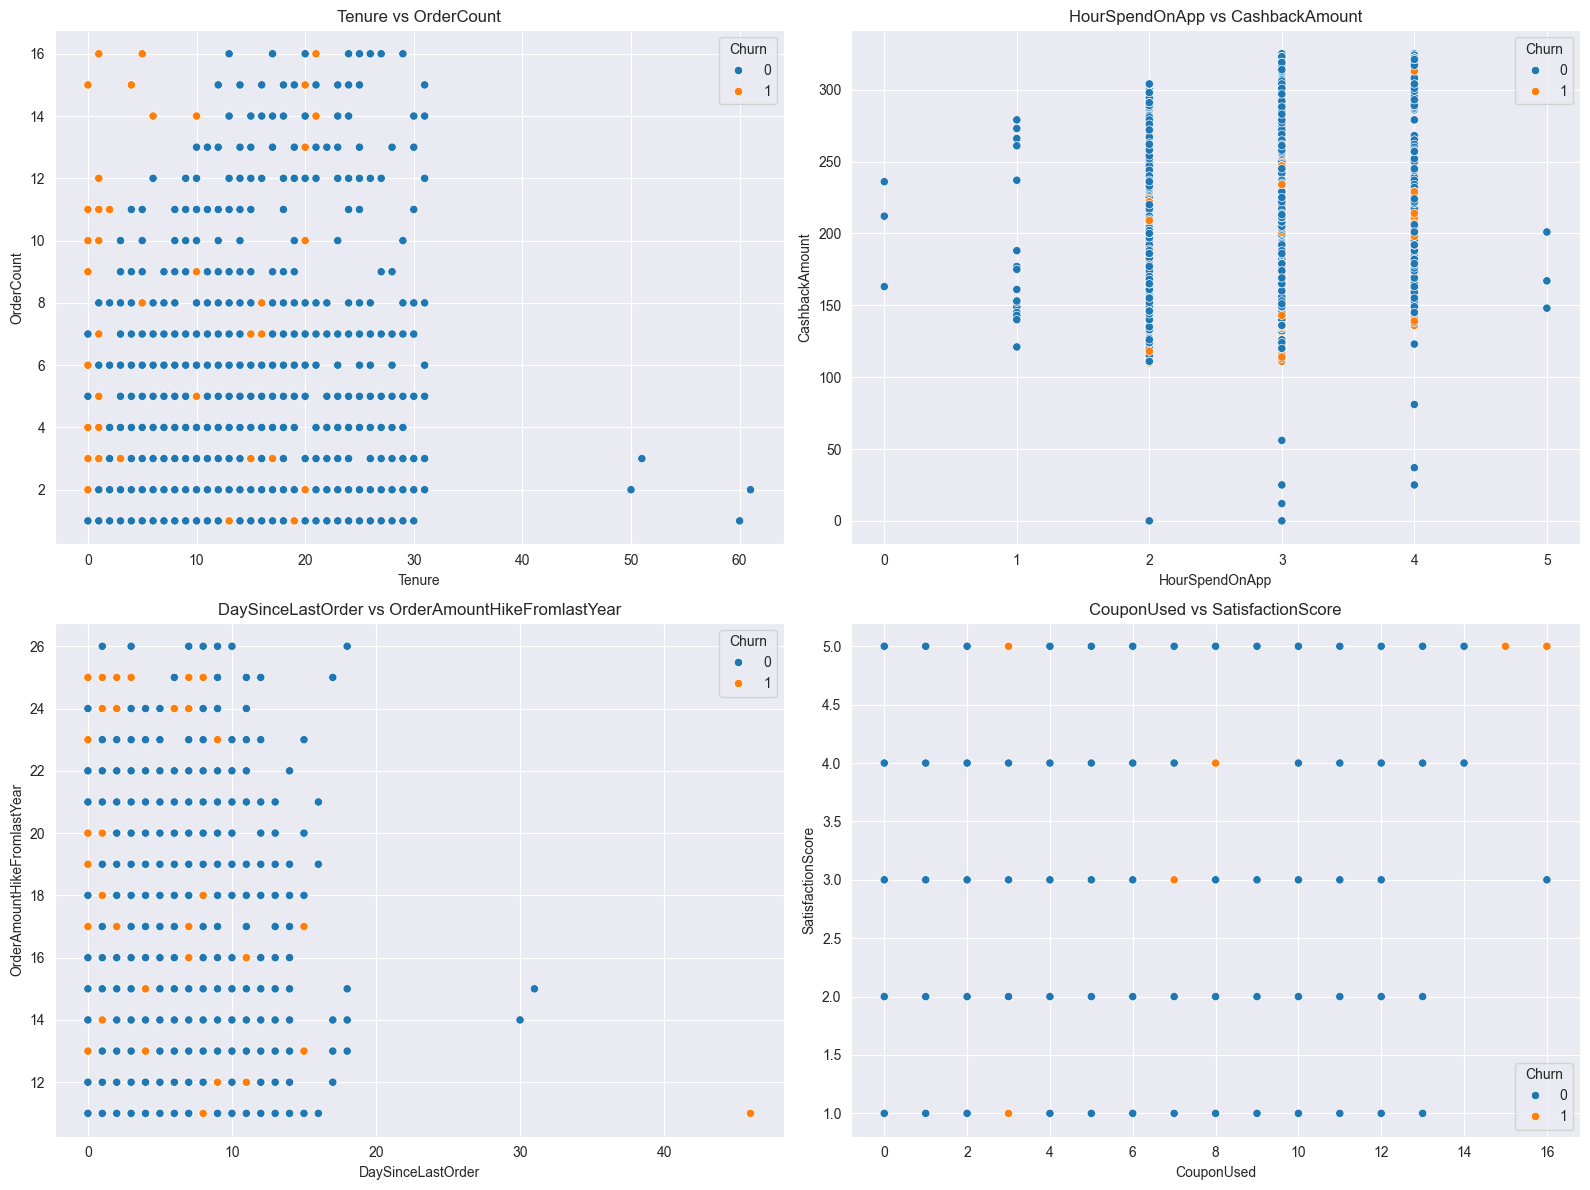

In [10]:
# Scatter plots for selected features
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
sns.scatterplot(x='Tenure', y='OrderCount', hue='Churn', data=df)
plt.title('Tenure vs OrderCount')

plt.subplot(2, 2, 2)
sns.scatterplot(x='HourSpendOnApp', y='CashbackAmount', hue='Churn', data=df)
plt.title('HourSpendOnApp vs CashbackAmount')

plt.subplot(2, 2, 3)
sns.scatterplot(x='DaySinceLastOrder', y='OrderAmountHikeFromlastYear', hue='Churn', data=df)
plt.title('DaySinceLastOrder vs OrderAmountHikeFromlastYear')

plt.subplot(2, 2, 4)
sns.scatterplot(x='CouponUsed', y='SatisfactionScore', hue='Churn', data=df)
plt.title('CouponUsed vs SatisfactionScore')

plt.tight_layout()
plt.savefig('eda/scatter_plots.png')
plt.show()

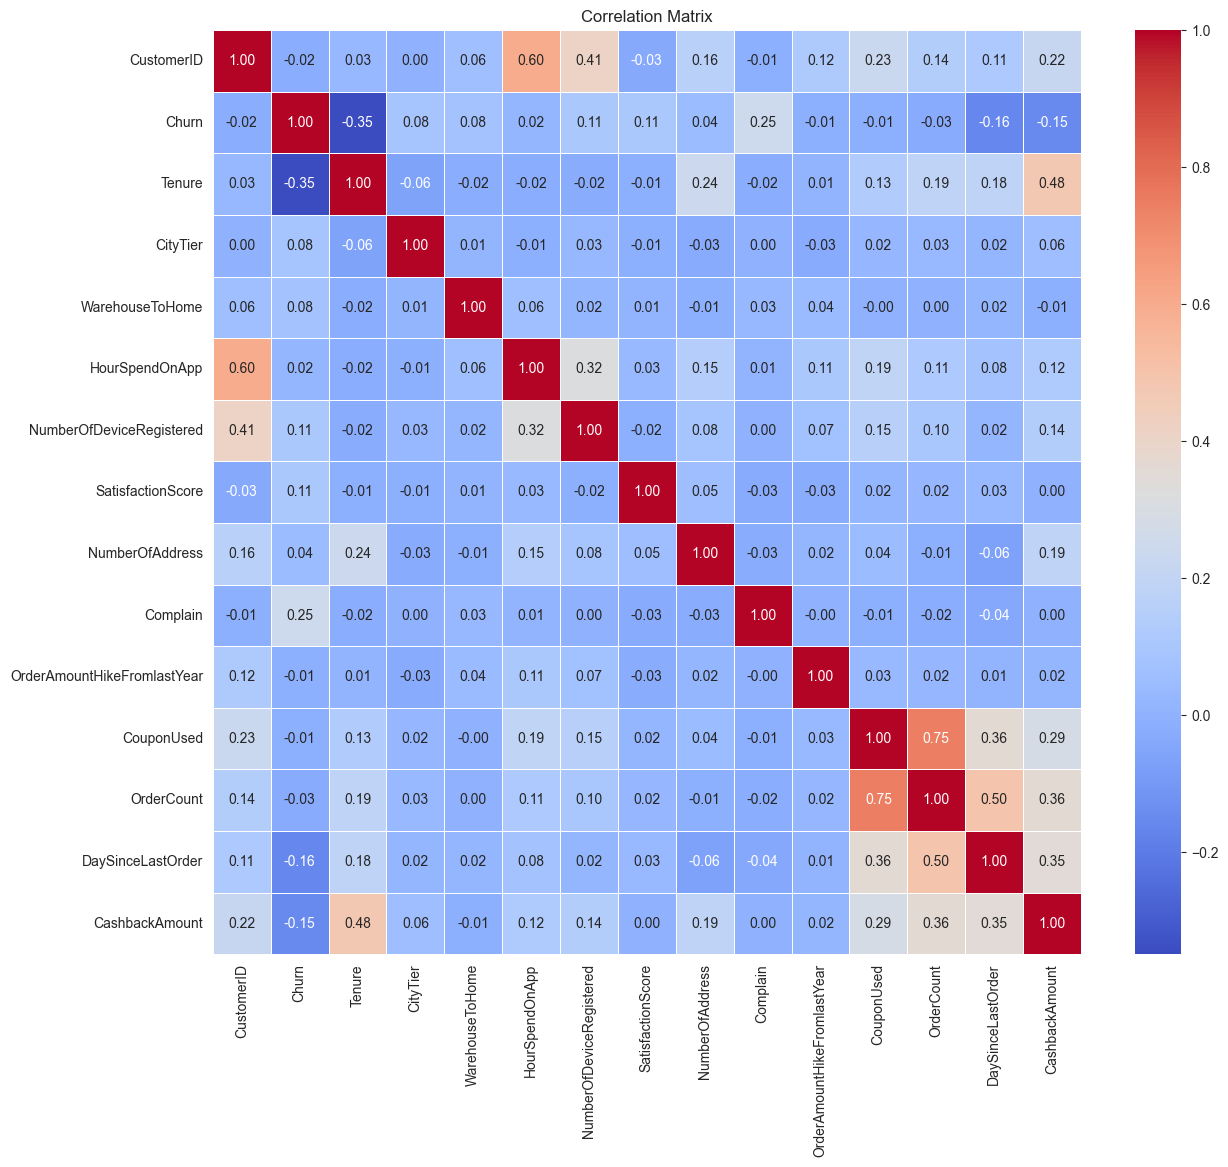

In [11]:
# Correlation matrix
plt.figure(figsize=(14, 12))
corr_matrix = df.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.savefig('eda/correlation_matrix.png')
plt.show()

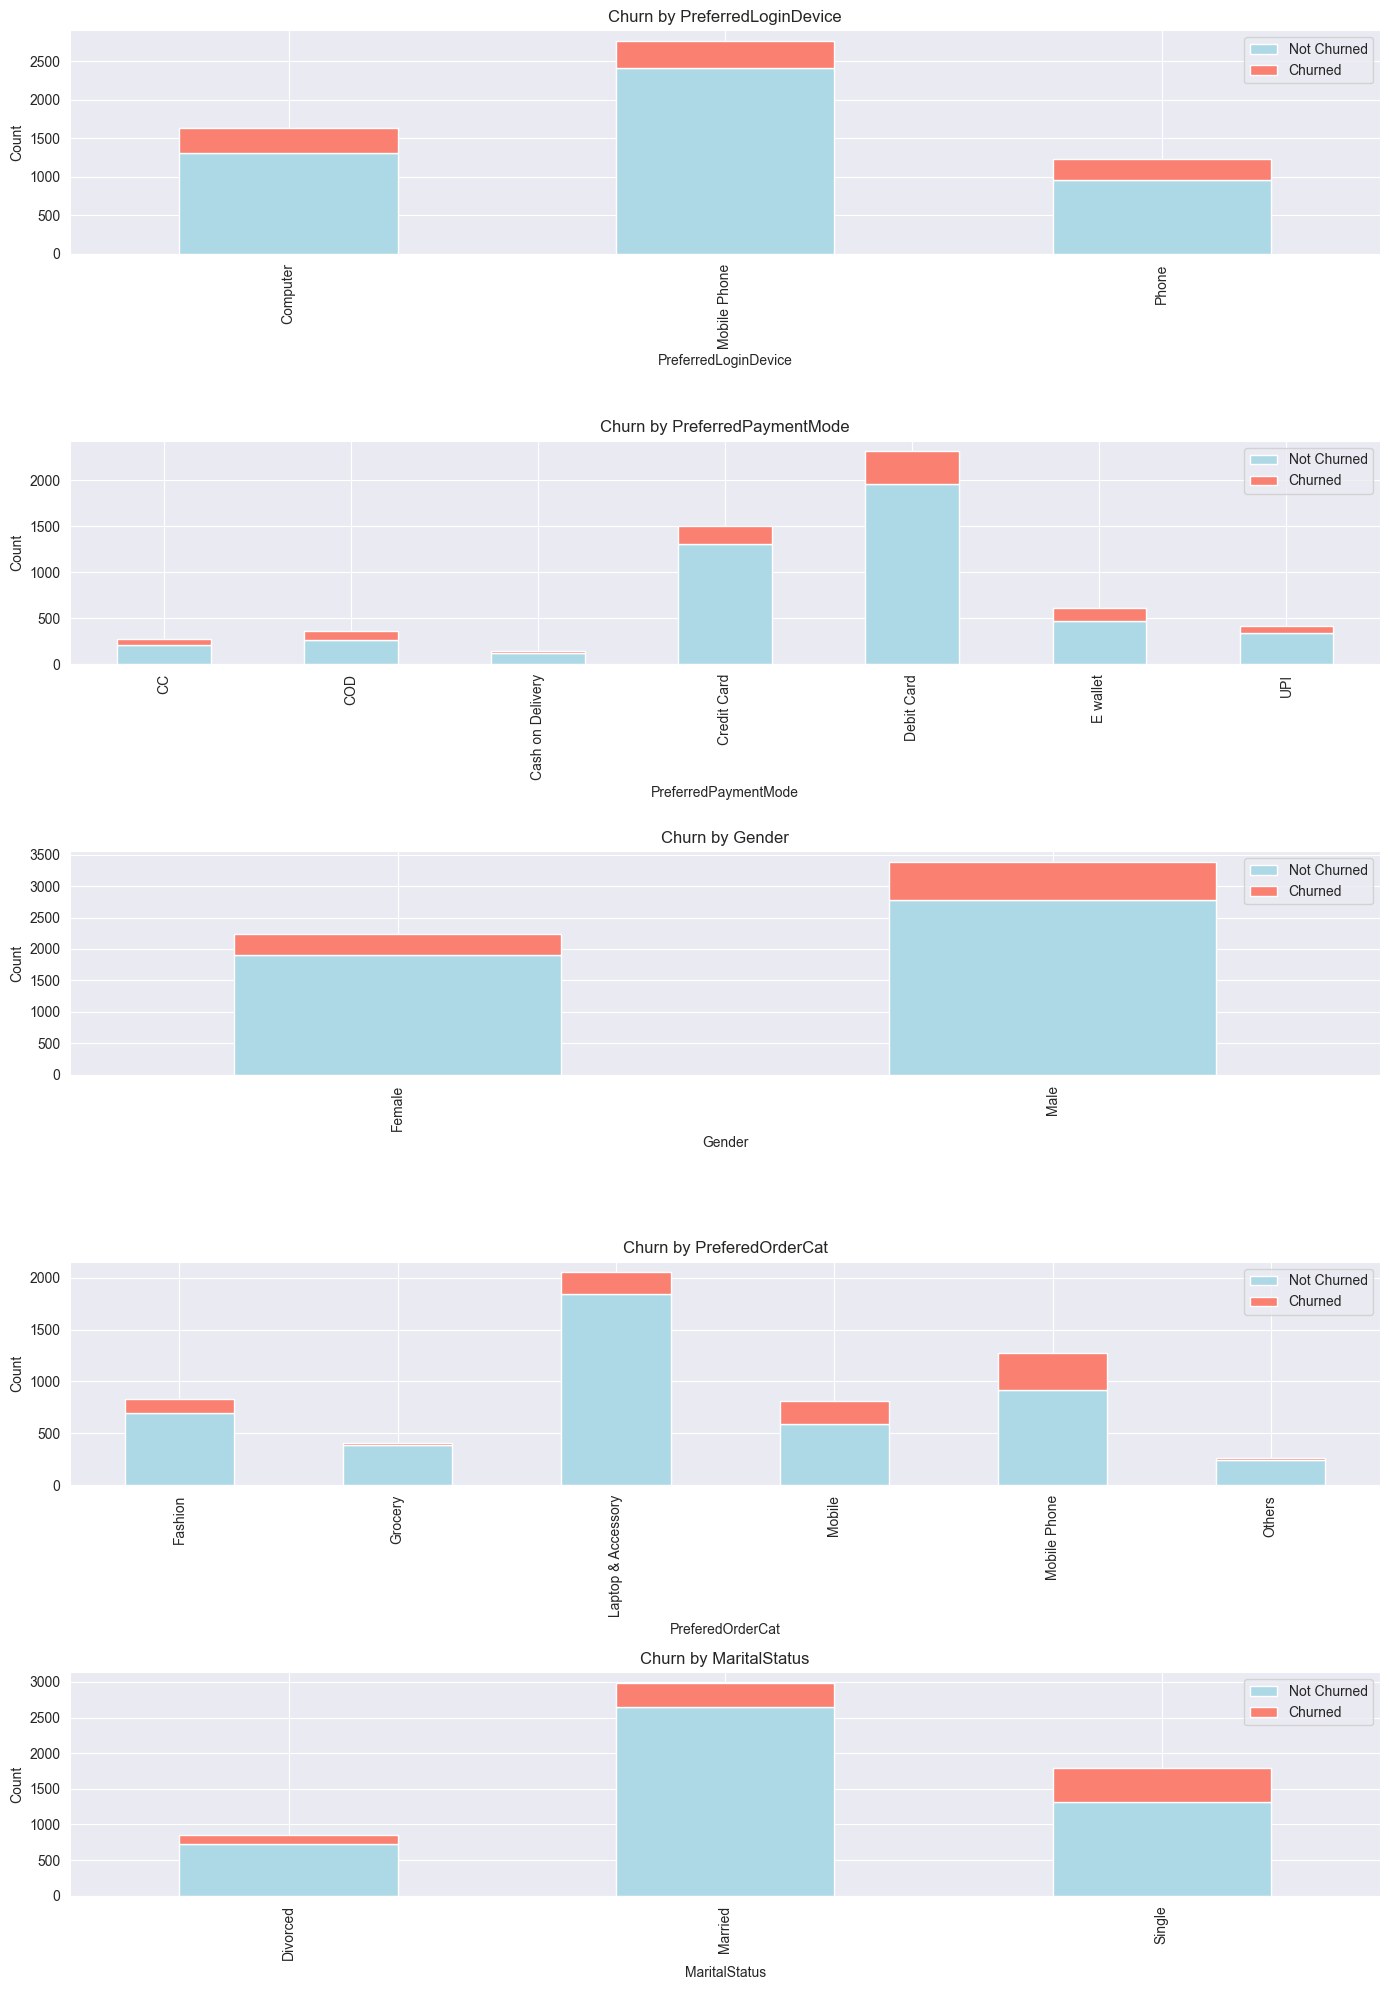

In [12]:
# Categorical features analysis
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
if categorical_features:
    plt.figure(figsize=(14, len(categorical_features) * 4))
    for i, feature in enumerate(categorical_features, 1):
        plt.subplot(len(categorical_features), 1, i)
        category_counts = df.groupby([feature, 'Churn']).size().unstack()
        category_counts.plot(kind='bar', stacked=True, ax=plt.gca(), color=['lightblue', 'salmon'])
        plt.title(f'Churn by {feature}')
        plt.xlabel(feature)
        plt.ylabel('Count')
        plt.legend(['Not Churned', 'Churned'])
    plt.tight_layout()
    plt.savefig('eda/categorical_analysis.png')
    plt.show()

## 3. Data Preprocessing

In [16]:
# Encode categorical variables
df_processed = pd.get_dummies(df, drop_first=True)
df_processed = df_processed.dropna()

# Drop CustomerID if it exists in the processed data
if 'CustomerID' in df_processed.columns:
    df_processed = df_processed.drop('CustomerID', axis=1)

# Separate features and target
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# Split the data into train, validation, and test sets (70%, 20%, 10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 2641 samples
Validation set size: 755 samples
Test set size: 378 samples


In [17]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## 4. PCA Analysis

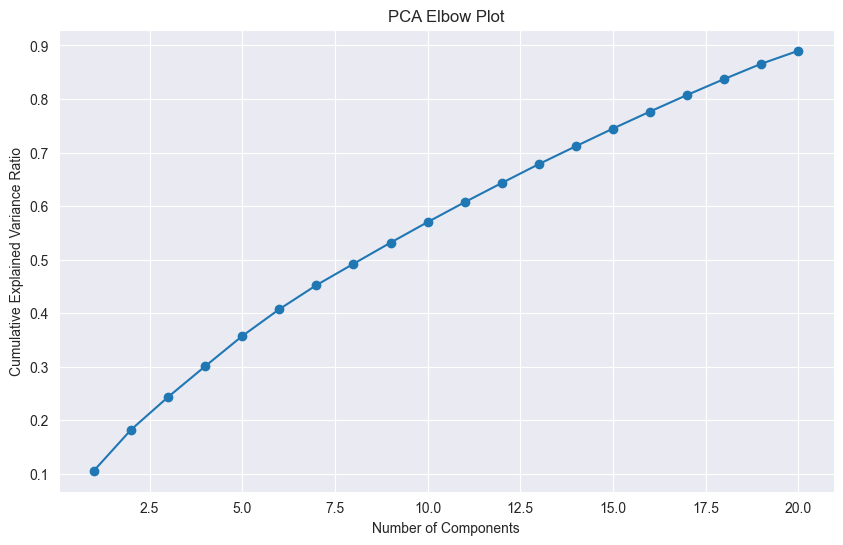

In [18]:
# Elbow plot to find optimal number of components
n_components = min(X_train_scaled.shape[1], 20)
explained_variance_ratios = []

for i in range(1, n_components + 1):
    pca = PCA(n_components=i)
    pca.fit(X_train_scaled)
    explained_variance_ratios.append(sum(pca.explained_variance_ratio_))

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), explained_variance_ratios, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Elbow Plot')
plt.grid(True)
plt.savefig(f'{train_results_folder}/pca_elbow_plot.png')
plt.show()

In [19]:
# Find the optimal number of components (where explained variance > 0.95)
optimal_n_components = 20
for i, variance in enumerate(explained_variance_ratios, 1):
    if variance >= 0.95:
        optimal_n_components = i
        break

if optimal_n_components == 0:
    optimal_n_components = n_components

print(f"Optimal number of components: {optimal_n_components}")

Optimal number of components: 20


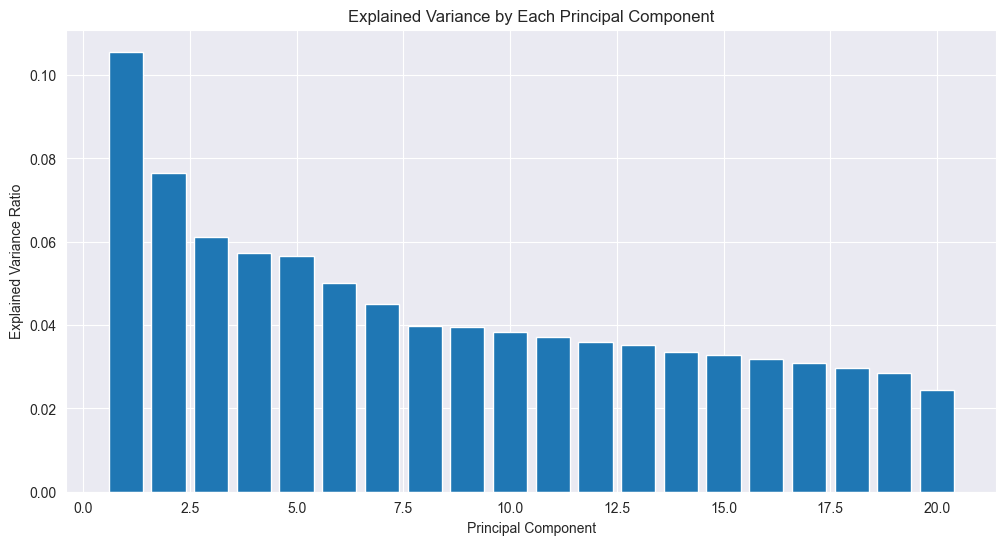

In [20]:
# Apply PCA with the optimal number of components
pca = PCA(n_components=optimal_n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Explained variance by each component
plt.figure(figsize=(12, 6))
plt.bar(range(1, optimal_n_components + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Each Principal Component')
plt.savefig(f'{train_results_folder}/pca_explained_variance.png')
plt.show()

## 5. Decision Tree with GridSearchCV

In [21]:
# Helper function for ROC curve
def plot_roc_curve(model, X, y, dataset_name):
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{dataset_name} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset_name} ROC Curve')
    plt.legend(loc="lower right")

In [28]:
# Function to evaluate model and save results
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, dataset_name):
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    # Create a DataFrame for the metrics
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Train': [train_accuracy, train_precision, train_recall, train_f1],
        'Validation': [val_accuracy, val_precision, val_recall, val_f1],
        'Test': [test_accuracy, test_precision, test_recall, test_f1]
    })
    
    # Save metrics to CSV
    metrics_df.to_csv(f'{train_results_folder}/{dataset_name}_metrics.csv', index=False)
    
    # Display metrics
    print(f"\nMetrics for {dataset_name}:")
    print(metrics_df)
    
    # Plot and save confusion matrices
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    train_cm = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Train Confusion Matrix')
    
    plt.subplot(1, 3, 2)
    val_cm = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Validation Confusion Matrix')
    
    plt.subplot(1, 3, 3)
    test_cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Test Confusion Matrix')
    
    plt.tight_layout()
    plt.savefig(f'{train_results_folder}/{dataset_name}_confusion_matrices.png')
    plt.show()
    
    # Plot and save ROC curve
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plot_roc_curve(model, X_train, y_train, 'Train')
    
    plt.subplot(1, 3, 2)
    plot_roc_curve(model, X_val, y_val, 'Validation')
    
    plt.subplot(1, 3, 3)
    plot_roc_curve(model, X_test, y_test, 'Test')
    
    plt.tight_layout()
    plt.savefig(f'{train_results_folder}/{dataset_name}_roc_curves.png')
    plt.show()
    
    # Classification report
    print("\nClassification Report - Train:")
    print(classification_report(y_train, y_train_pred))
    
    print("\nClassification Report - Validation:")
    print(classification_report(y_val, y_val_pred))
    
    print("\nClassification Report - Test:")
    print(classification_report(y_test, y_test_pred))
    
    # Save classification reports
    with open(f'{train_results_folder}/{dataset_name}_classification_reports.txt', 'w') as f:
        f.write("Classification Report - Train:\n")
        f.write(classification_report(y_train, y_train_pred))
        f.write("\nClassification Report - Validation:\n")
        f.write(classification_report(y_val, y_val_pred))
        f.write("\nClassification Report - Test:\n")
        f.write(classification_report(y_test, y_test_pred))

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Set up the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 50],
    'class_weight': ['balanced', {0: 1, 1: 10}, {0:1, 1:20}, {0:1, 1:50}, {0:1, 1:100}],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10],
    'criterion': ['gini', 'entropy']
}

# Initialize the decision tree classifier
dt_classifier = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=dt_classifier,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train_pca, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Get the best model
best_dt = grid_search.best_estimator_

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Best parameters: {'class_weight': {0: 1, 1: 50}, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


## 6. Model Evaluation


Metrics for decision_tree_pca:
      Metric     Train  Validation      Test
0   Accuracy  0.995456    0.916556  0.947090
1  Precision  0.974630    0.811111  0.878049
2     Recall  1.000000    0.613445  0.705882
3   F1 Score  0.987152    0.698565  0.782609


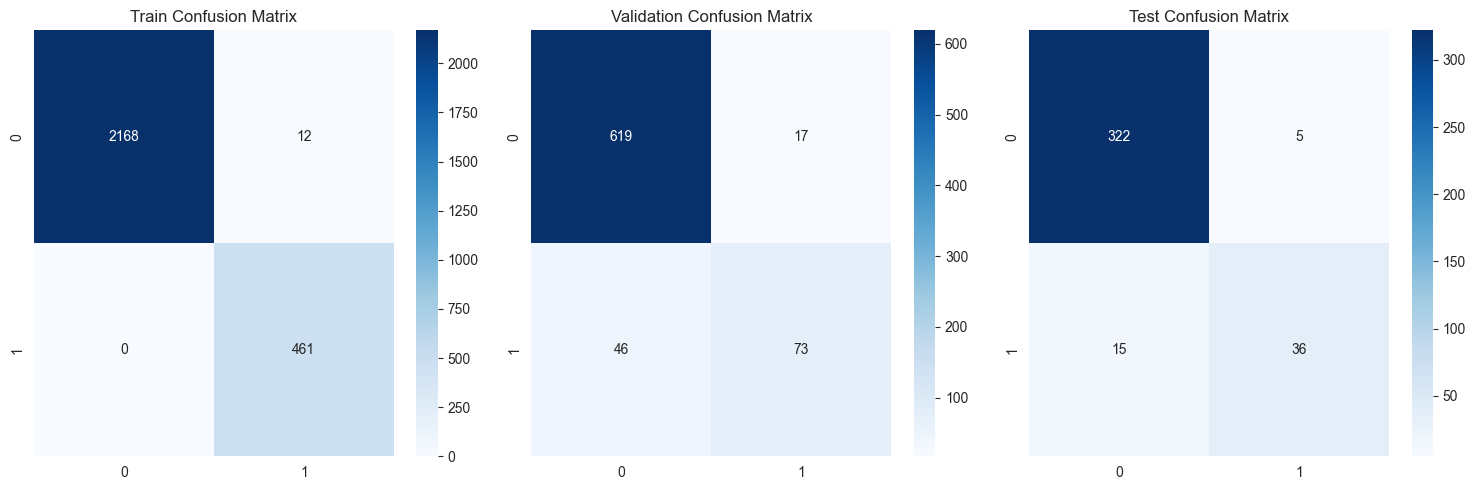

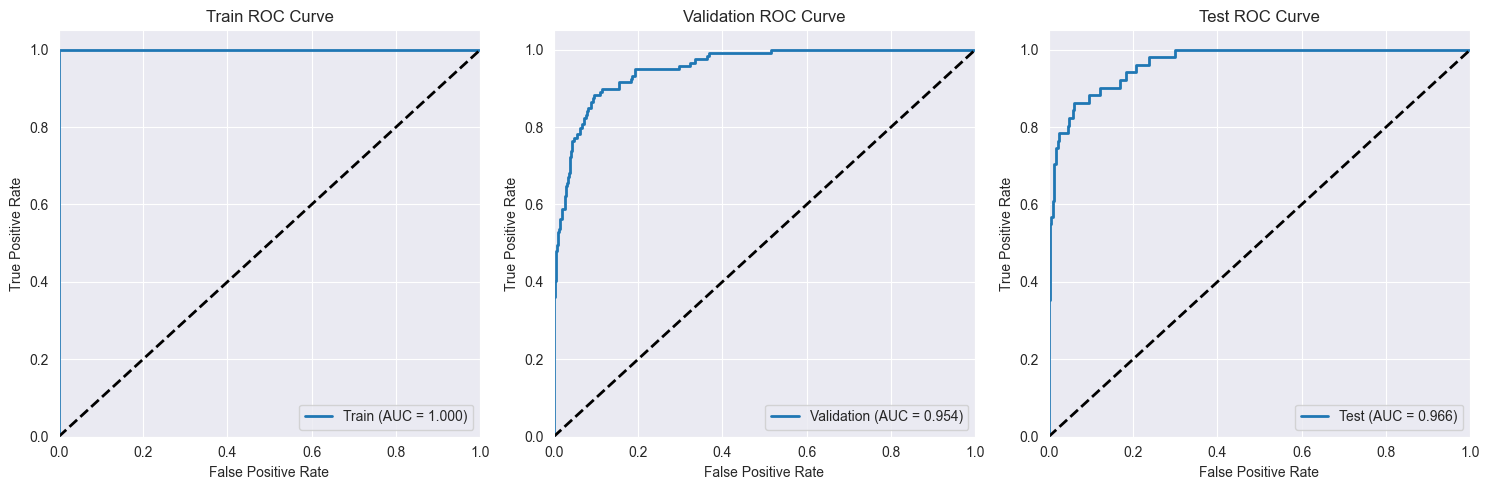


Classification Report - Train:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2180
           1       0.97      1.00      0.99       461

    accuracy                           1.00      2641
   macro avg       0.99      1.00      0.99      2641
weighted avg       1.00      1.00      1.00      2641


Classification Report - Validation:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       636
           1       0.81      0.61      0.70       119

    accuracy                           0.92       755
   macro avg       0.87      0.79      0.83       755
weighted avg       0.91      0.92      0.91       755


Classification Report - Test:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       327
           1       0.88      0.71      0.78        51

    accuracy                           0.95       378
   macro avg       0.92     

In [35]:
# Evaluate the model
evaluate_model(best_dt, X_train_pca, y_train, X_val_pca, y_val, X_test_pca, y_test, "decision_tree_pca")

## 7. Feature Importance Analysis

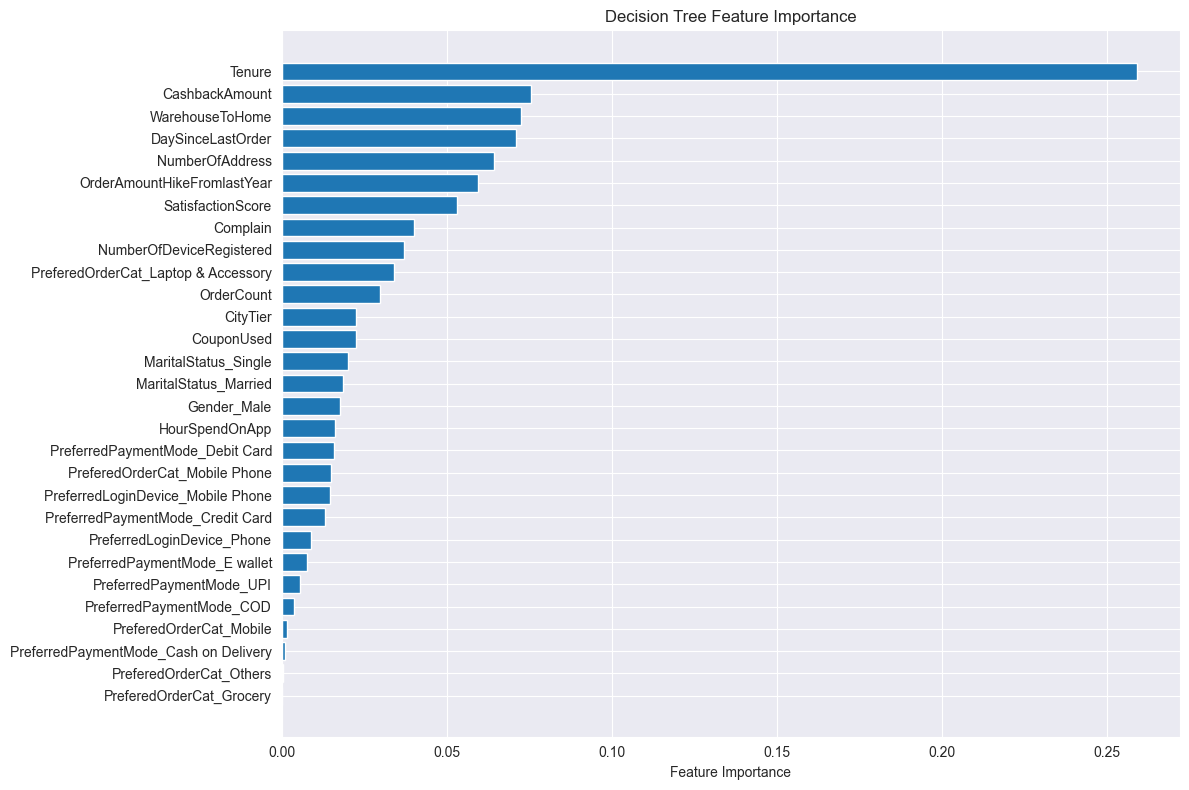

In [37]:
# Train a decision tree on the original features
best_params = grid_search.best_params_
dt_original = RandomForestClassifier(**best_params, random_state=42)
dt_original.fit(X_train_scaled, y_train)

# Get feature importances
feature_importances = dt_original.feature_importances_
feature_names = X.columns

# Sort features by importance
sorted_idx = feature_importances.argsort()
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('RFC Feature Importance')
plt.tight_layout()
plt.savefig(f'{train_results_folder}/feature_importance.png')
plt.show()

## 8. Summary and Conclusions

In [38]:
print("\n=== Summary ===")
print(f"Best Decision Tree Parameters: {grid_search.best_params_}")
print(f"Training Accuracy: {accuracy_score(y_train, best_dt.predict(X_train_pca)):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, best_dt.predict(X_val_pca)):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, best_dt.predict(X_test_pca)):.4f}")

# Save the model parameters and summary
with open(f'{train_results_folder}/model_summary.txt', 'w') as f:
    f.write("=== Churn Prediction Model Summary ===\n\n")
    f.write(f"Timestamp: {timestamp}\n")
    f.write(f"Original dataset shape: {df.shape}\n")
    f.write(f"Number of PCA components used: {optimal_n_components}\n")
    f.write(f"Cumulative explained variance: {explained_variance_ratios[optimal_n_components-1]:.4f}\n\n")
    f.write(f"Best Decision Tree Parameters: {grid_search.best_params_}\n")
    f.write(f"Training Accuracy: {accuracy_score(y_train, best_dt.predict(X_train_pca)):.4f}\n")
    f.write(f"Validation Accuracy: {accuracy_score(y_val, best_dt.predict(X_val_pca)):.4f}\n")
    f.write(f"Test Accuracy: {accuracy_score(y_test, best_dt.predict(X_test_pca)):.4f}\n\n")
    f.write("Top 5 Most Important Features:\n")
    for i in sorted_idx[-5:]:
        f.write(f"- {feature_names[i]}: {feature_importances[i]:.4f}\n")

print("\nAll results have been saved to the folder:", train_results_folder)


=== Summary ===
Best Decision Tree Parameters: {'class_weight': {0: 1, 1: 50}, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training Accuracy: 0.9955
Validation Accuracy: 0.9166
Test Accuracy: 0.9471

All results have been saved to the folder: trainresults/20250303_203039
